In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import MaxPooling2D, AvgPool2D, InputLayer, Dropout
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image
from tensorflow.keras.preprocessing import image

In [3]:
import skimage
import skimage.transform

In [4]:
import sys
sys.path.append('../')
from utilities import Timer

In [5]:
# Image display utility
def show_image(image):
    figsize = image.shape.as_list()[:-1]
    figsize = tuple(size / 72 for size in figsize)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.axis('off')
    plt.show()

In [ ]:
original_img = download(url, max_dim=500)
base_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

# Maximize the activations of these layers
names = ['block5_conv1', 'block5_conv2']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
deepdream   = DeepDream(dream_model)
dream_img   = run_deep_dream_simple(img=original_img, steps=100, step_size=1.0)

show_image(postprocess_image(dream_img))

big = skimage.transform.pyramids.pyramid_expand(dream_img.numpy(), multichannel=True)
big = tf.convert_to_tensor(big)
show_image(postprocess_image(big))

In [ ]:
image_path = '../dream-base-images/marco3.png'

width = height = 224

In [ ]:
# Load the classnames
df = pd.read_excel('../dataset/artist-breakdown-annotated.xlsx')
df = df[df.fillna(0).keep.astype(bool)]
class_names = df.artist.unique()
class_names.sort()

In [ ]:
model_name = 'vgg19-INet-down3'
base_model = load_model(f'../classification/logs/models/{model_name}.hdf5')

# Replace max pooling with avg pooling to promote gradient flow
model = Sequential([InputLayer(input_shape = (width, height, 3))])

for layer in base_model.layers[:-1]:
    if isinstance(layer, MaxPooling2D):
        pool = AvgPool2D().from_config(layer.get_config())
        model.add(pool)
    elif isinstance(layer, Dropout):
        pass
    else:
        model.add(layer)
        
    if layer.name == 'block5_conv2':
        break


# # Add the top layer without softmax
# top_config = base_model.layers[-1].get_config()
# top_config['activation'] = 'linear'
# top_layer = base_model.layers[-1].from_config(top_config)
# model.add(top_layer)

model.build()

In [ ]:
model.summary()

In [ ]:
# Class to manage the image processing pre- and post-dream.
# Terminology
#  - The base image is what is dreamt upon by the dreamer.
#     The base image itself can be an earlier dream
#  - After dreaming, a dream should be registered with the DreamImage instance
#  - Then it can be decoded using a normalization scheme and optional resizing

# Scalers
def min_max_scale(tensor):
    min_ = tf.reduce_min(tensor)
    max_ = tf.reduce_max(tensor)
    return (tensor - min_) / (max_ - min_)
def clip_scaler(tensor):
    return (1/2) * (1 + tf.clip_by_value(tensor, -1, 1))


class DreamImage:
    def __init__(self, image_path, width, height, normalizer = 'min-max'):
        # Load the image from disk
        self.img = tf.io.read_file(image_path)
        if image_path.endswith('.png'):
            self.img = tf.image.decode_png(self.img, channels = 3)
        elif image_path.endswith('.jpg'):
            self.img = tf.image.decode_jpg(self.img, channels = 3)
        else:
            raise TypeError(f'File format for {path} not supported or detected')
        self.img = tf.image.convert_image_dtype(self.img, tf.float32)
        
        # Set the target width and height
        self.width  = width
        self.height = height
        
        # Set the normalizer
        normalizers = {
            'sigmoid' : tf.sigmoid,
            'min-max' : min_max_scale,
            'clip'    : clip_scaler
        }
        self.normalizer = normalizers[normalizer]
        
    def show_base(self):
        show_image(self.img)
        
    def prepare_base(self):
        # Resize
        self.resized_base = tf.image.resize(self.img, [self.width, self.height])
        
        # Center the image
        # self.mean_correction = tf.reduce_mean(self.resized_base)
        self.mean_correction = 0
        
        # img = self.resized_base - self.mean_correction
        img = self.resized_base
        
        # Add noise
        img = img + tf.random.normal(img.shape, stddev = .05)
        
        img = tf.expand_dims(img, axis = 0)
        return img
        
    def decode_dream(self, dream, full_size = False):
        # Prepare the dream
        dream    = tf.squeeze(dream)
        dream    = self.normalizer(dream)
        
        if full_size:
            dream_delta = dream - self.resized_base
            dream_delta = tf.image.resize(dream_delta, self.img.shape.as_list()[:-1])
            img         = dream_delta + self.img
        else:
            img         = dream
        img         = img - tf.reduce_min(img)
        img         = img / tf.reduce_max(img)
        return img

    def show_dream(self, dream, full_size = False):
        dream = self.decode_dream(dream, full_size = full_size)
        show_image(dream)

In [ ]:
class DeepDream(tf.Module):
    def __init__(self, model, steps, learning_rate, artist_vect):
        self.model         = model
        self.steps         = tf.convert_to_tensor(steps, dtype = tf.int32)
        self.learning_rate = tf.convert_to_tensor(learning_rate, dtype = tf.float32)
        self.artist_vect   = tf.convert_to_tensor(artist_vect, dtype = tf.float32)
        
    @tf.function(input_signature=(tf.TensorSpec(shape=[1,None,None,3], dtype=tf.float32),))
    def __call__(self, img):
        for n in tf.range(self.steps):
            # Compute the loss so that the gradient may be computed
            with tf.GradientTape() as tape:
                tape.watch(img)
                activations = self.model(img)
                loss = tf.reduce_sum(tf.math.square(activations))
                # loss        = tf.tensordot(self.artist_vect, activations, [0,1])
                # loss        = tf.squeeze(loss)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            # gradients -= tf.math.reduce_mean(gradients)
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*self.learning_rate

        return img

In [ ]:
dreamer = DeepDream(model, 100, 0.01, class_names == 'Pablo Picasso')
marco   = DreamImage(image_path, width, height)

In [ ]:
Timer.start()
dream = dreamer(marco.prepare_base())
Timer.end()

In [ ]:
marco.show_dream(dream, full_size = True)

In [ ]:
# Build a layer of just weights
x = keras.layers.Dense(224*224, input_shape = (0, 0), use_bias = True)
y = keras.models.Sequential(x)
y.build()
x.get_weights()

In [ ]:
show_image(min_max_scale(out))

## Original Deep Dream

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

original_img.shape

base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)


base_model.summary()

def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)


class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

deepdream = DeepDream(dream_model)


def run_deep_dream_simple(img, steps=10, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>5:
      run_steps = tf.constant(5)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)


In [ ]:
img = tf.keras.applications.inception_v3.preprocess_input(img)

In [ ]:
Timer.start()
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)
Timer.end()

In [ ]:
Timer.start()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

Timer.end()

In [ ]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1] 
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

shift_down, shift_right, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)


In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

get_tiled_gradients = TiledGradients(dream_model)


In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

Timer.start()
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)
Timer.end()

### Test re-sampling

In [ ]:
# Downsample/upsample is trick
img = tf.io.read_file(image_path)
img = tf.image.decode_png(img, channels = 3)

fig, ax = plt.subplots(figsize = (15, 20))
ax.imshow(img)
plt.axis('off')
print(img.shape)
plt.show()

img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, [width, height])

fig, ax = plt.subplots()
ax.imshow(img)
plt.axis('off')
plt.show()

img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, [4032, 3024])

fig, ax = plt.subplots(figsize = (15, 20))
ax.imshow(img)
plt.axis('off')
plt.show()

## Deep Dream Modification 1
Run on a VGG19 architecture

In [40]:
def preprocess_image(image):
    out = tf.keras.applications.vgg19.preprocess_input(image)
    out = tf.convert_to_tensor(out)
    return out

def postprocess_image(image):
    image = image.numpy()
    image[:, :, 0] += 103.939
    image[:, :, 1] += 116.779
    image[:, :, 2] += 123.68
    out = np.clip(image[:, :, ::-1], 0, 255).astype('uint8')
    return tf.convert_to_tensor(out)

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)


class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            # img = tf.clip_by_value(img, -1, 1)

        return loss, img

    def run_deep_dream_simple(self, img, steps=10, step_size=0.01):
        # Convert from uint8 to the range expected by the model.
        img = tf.keras.applications.vgg19.preprocess_input(img)
        img = tf.convert_to_tensor(img)
        img = tf.image.resize(img, [224, 224])
        step_size = tf.convert_to_tensor(step_size)
        steps_remaining = steps
        step = 0
        while steps_remaining:
            if steps_remaining>100:
                run_steps = tf.constant(100)
            else:
                run_steps = tf.constant(steps_remaining)
            steps_remaining -= run_steps
            step += run_steps

            loss, img = self(img, run_steps, tf.constant(step_size))

        return img

2.15 seconds elapsed


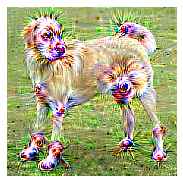

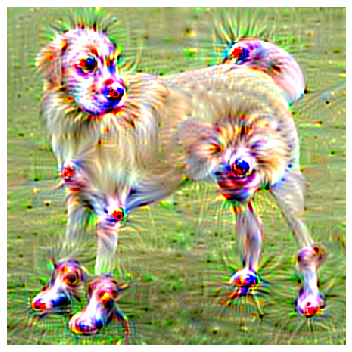

In [41]:
original_img = download(url, max_dim=500)
base_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

# Maximize the activations of these layers
names =  ['block5_conv1', 'block5_conv2']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
deepdream   = DeepDream(dream_model)
Timer.start()
dream_img   = deepdream.run_deep_dream_simple(img=original_img, steps=100, step_size=1.0)
Timer.end()

show_image(postprocess_image(dream_img))

big = skimage.transform.pyramids.pyramid_expand(dream_img.numpy(), multichannel=True)
big = tf.convert_to_tensor(big)
show_image(postprocess_image(big))

In [42]:
from tensorflow.keras.layers import Flatten, Dense

In [59]:
base_model = tf.keras.applications.vgg19.VGG19(include_top=True, weights='imagenet')
model      = Sequential(base_model.layers[:-4])

model.add(Flatten(data_format = 'channels_last', name = 'flatten'))

fc1 = Dense.from_config(base_model.layers[-3].get_config())
model.add(fc1)
fc1.set_weights(base_model.layers[-3].get_weights())

fc2 = Dense.from_config(base_model.layers[-2].get_config())
model.add(fc2)
fc2.set_weights(base_model.layers[-2].get_weights())

top_config   = base_model.layers[-1].get_config()
top_config['activation'] = 'linear'
predictions = Dense.from_config(top_config)
model.add(predictions)
predictions.set_weights(base_model.layers[-1].get_weights())

# Create the feature extraction model
# names =  ['fc2', 'predictions']
names = ['predictions', 'fc2']
layers = [model.get_layer(name).output for name in names]
dream_model = tf.keras.Model(inputs=model.input, outputs=layers)
dream_model.build((None, 224, 224, 3))

deepdream   = DeepDream(dream_model)

Timer.start()
dream_img   = deepdream.run_deep_dream_simple(img=original_img, steps=100, step_size=0.5)
Timer.end()

show_image(postprocess_image(dream_img))

big = skimage.transform.pyramids.pyramid_expand(dream_img.numpy(), multichannel=True)
big = tf.convert_to_tensor(big)
show_image(postprocess_image(big))

ResourceExhaustedError: OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: fc1_26/kernel/Initializer/random_uniform/

https://www.reddit.com/r/tensorflow/comments/e89v3q/inaccessibletensorerror_deepdream_tutorial/